<a href="https://colab.research.google.com/github/kumagaimasahito/2019/blob/master/ExtremeClustering_QA/Greedy/greedy_BiDViT%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Visualization Tool by Greedy
Implemenntation of BiDViT by Greedy.
This is easier to use BiDViT by Greedy.   
If you want to learn algorithm movement, I reccomend you execute greedy_BiDViT.ipynb before this ipynb.

## 準備
- ライブラリのインストール
- データの準備

In [0]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from scipy.spatial import distance
from sklearn.datasets import load_iris
iris = load_iris()

In [0]:
# pd.DataFrame -> numpy array
data = np.array(iris.data)

In [0]:
weight = [1] * len(data)

In [0]:
answer = iris.target

## BiDViT Computation Time Measure Function

In [0]:
# Data Partitioning

"vinary median cut by variance"
def vinary_medcut(data):
  var_data = np.var(data, axis=0)
  med_data = np.median(data, axis=0)

  chunk = [0] * len(data)
  dimension = len(data[0])

  flag = 0
  label = 0
  rep_d = 0

  for i in range(len(data)):
    if len(data)%2 == 1: # number of datapoints is odd.
      for d in range(dimension):
        if var_data[d] >= var_data[rep_d]: # variance of dimennsion >= variance of representive dimension
          rep_d = d
      if med_data[rep_d] >=  data[:,rep_d][i]: # if median of representive dimension >= every data, every chunk is determined below. 
        chunk[i] = label
      elif med_data[rep_d] <  data[:,rep_d][i]: # if median of representive dimension < every data, every chunk is determined below.
        chunk[i] = label+1

    elif len(data)%2 == 0: # number of datapoints is even .
      for d in range(dimension):
        if var_data[d] >= var_data[rep_d]: # variance of dimennsion >= variance of representive dimension
          rep_d = d
      if med_data[rep_d] > data[:,rep_d][i]: # if median of representive dimension > every data, every chunk is determined below.
        chunk[i] = label
      elif med_data[rep_d] < data[:,rep_d][i]: # if median of representive dimension < every data, every chunk is determined below.
        chunk[i] = label+1
      elif med_data[rep_d] == data[:,rep_d][i]: # if median of representive dimension = a data the former and latter 's label are different.
        if flag == 0: # the former's label is below.
          chunk[i] = label
          flag += 1
        elif flag == 1: # the latter's label is below.
          chunk[i] = label+1
          flag == 0

  return chunk


"main function of median cut based on variance"
def var_medcut(data,kappa):
  chunk = vinary_medcut(data)
  prev_label = 2
  max_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == 0], axis=0)

  while (max_points > kappa):

    # get the max data points of any chunks ,the max data points chunks label number
    max_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == 0], axis=0)
    label_max_data = 0
    for j in range(prev_label):
      prev_points = np.count_nonzero([i for i, x in enumerate(chunk) if x == j], axis=0)
      if prev_points >= max_points:
        max_points = prev_points
        label_max_data = j
    if max_points <= kappa:
      break
    
    # vinary median cut targeted to the max variance chunk
    prev_data = np.delete(data, [i for i, x in enumerate(chunk) if not x == label_max_data], axis=0) # data of max variance chunk
    prev_chunk = vinary_medcut(prev_data)

    # update chunk number
    prev_chunk = [label_max_data if i == 0 else prev_label for i in prev_chunk]
    tmp = 0
    for i in range(len(chunk)):
      if chunk[i] == label_max_data:
        chunk[i] = prev_chunk[tmp]
        tmp += 1

    prev_label += 1

  return chunk



# Chunk Coarsening

"solve the Neighborhood matrix of data chunks"
def N_solver_greedy(data_chunk, epsilon):
  dist_matrix = distance.cdist(data_chunk, data_chunk, metric='euclidean')
  N = np.zeros((len(data_chunk),len(data_chunk)))

  for i in range(len(data_chunk)):
    for j in range(len(data_chunk)):
      if j == i:
        continue
      else:
        if dist_matrix[i][j] < epsilon:
          N[i][j] = 1
        else:
          N[i][j] = 0

  return N


"solve the solutions of each chunks"

def coarsening_set_greedy(data_chunk, weight, epsilon):
  coarsening_start = time.time()
  solutions = [0] * len(data_chunk)
  raw_num = [i for i in range(len(data_chunk))]

  while (len(data_chunk) != 0):
    deg = [0] * len(data_chunk)
    N = N_solver_greedy(data_chunk, epsilon)

    for i in range(len(deg)):
      for j in range(len(N[i])):
        if N[i][j] == 1:
          deg[i] += weight[j]
        deg[i] = deg[i] / weight[i]

    degmin = np.argmin(deg)
    solutions[raw_num[degmin]] = 1
    data_chunk = np.delete(data_chunk, degmin, axis=0)
    raw_num = np.delete(raw_num, degmin, axis=0)

    data_chunk = np.delete(data_chunk, [i for i, x in enumerate(N[degmin]) if x == 1], axis=0)
    raw_num = np.delete(raw_num, [i for i, x in enumerate(N[degmin]) if x == 1], axis=0)

    coarsening_end = time.time()
    coarsening_time = coarsening_end - coarsening_start

  return solutions, coarsening_time



# Chunk Collapsing

"Solve new weight"
def w_updater(data_chunk, weight_chunk, solutions):
  S = np.delete(data_chunk, [i for i, x in enumerate(solutions) if x == 0], axis=0)
  P = data_chunk
  weight_cent = [0] * len(S)

  dist_matrix = distance.cdist(S, P, metric='euclidean')
  np.fill_diagonal(dist_matrix, np.inf)
  nearest = np.argmin(dist_matrix, axis=0)
  centroids = S

  for j in range(len(S)):
    for i in range(len(weight_chunk)):
      if nearest[i] == j:
        weight_cent[j] += weight_chunk[i]

  return centroids, weight_cent, nearest


"All Chunk Collapsing"
def all_w_updater_greedy(data, chunk_label, weight, epsilon=0.4):
  coarsening_time = 0
  collapsing_time = 0
  collapsing_start = time.time()

  chunk_set = [0] * (max(chunk_label) + 1)
  chunk_weight = [0] * (len(chunk_set))
  solutions = [0] * (len(chunk_set))
  centroids = [0] * (len(chunk_set))
  weight_cent = [0] * (len(chunk_set))
  nearest = [0] * (len(chunk_set))

  for chunk_num in range(len(chunk_set)):
    chunk_set = np.delete(data, [i for i, x in enumerate(chunk_label) if not x == chunk_num], axis=0)
    chunk_weight = np.delete(weight, [i for i, x in enumerate(chunk_label) if not x == chunk_num], axis=0)
    solutions[chunk_num], t1 = coarsening_set_greedy(chunk_set, chunk_weight, epsilon)
    centroids[chunk_num], weight_cent[chunk_num], nearest[chunk_num] = w_updater(chunk_set, chunk_weight, solutions[chunk_num])
    coarsening_time += t1
  collapsing_end = time.time()
  collapsing_time = collapsing_end - collapsing_start - coarsening_time

  return solutions, centroids, weight_cent, nearest, coarsening_time, collapsing_time



# Big Data Visualization Tool

"Measure computation time on BiDViT"
def time_BiDViT_greedy(data, weight, required_level=10, kappa=64, epsilon=0.4, ep_rate=2.0):
  other_start = time.time()
  raw_data_sum = len(data)
  tree_list = []
  data_list = []
  weight_list = []
  level = 0

  partition_time = 0
  coarsening_time = 0
  collapsing_time = 0

  while (level < required_level):
    data_list.append(data)
    weight_list.append(weight)

    partition_start = time.time()
    chunk = var_medcut(data,kappa)
    partition_end = time.time()
    partition_time += partition_end - partition_start

    solutions, centroids, weight_cent, nearest, t1, t3 = all_w_updater_greedy(data, chunk, weight, epsilon)
    coarsening_time += t1
    collapsing_time += t3

    next_data_sum = 0
    for i in range(len(nearest)):
      next_data_sum += len(centroids[i])
    
    next_data = [0] * next_data_sum
    next_weight = [0] * next_data_sum

    flag = 0
    for i in range(len(nearest)):
      for j in range(len(centroids[i])):
        next_data[j+flag] = centroids[i][j]
        next_weight[j+flag] = weight_cent[i][j]
      flag += len(centroids[i])
    
    cluster = [0] * len(chunk)

    for i in range(len(nearest)-1):
      nearest[i+1] += max(nearest[i])+1

    tmp = [0] * len(nearest)
    for i in range(len(chunk)):
      cluster[i] = nearest[chunk[i]][tmp[chunk[i]]]
      tmp[chunk[i]] += 1

    tree_list.append(cluster)
    level += 1

    if len(data) == len(next_data):
      break
    data = np.array(next_data)
    weight = next_weight

    epsilon = ep_rate * epsilon

  for i in range(len(tree_list)-1, 0, -1):
    for j in range(len(tree_list[i-1])):
      tree_list[i-1][j] = tree_list[i][tree_list[i-1][j]]
  represent = np.array(tree_list[0])
  other_end = time.time()
  other_time = other_end - other_start - partition_time - coarsening_time - collapsing_time

  return represent, partition_time, coarsening_time, collapsing_time, other_time

In [0]:
# クラスタリングの精度を図るF値を計算する関数
def evaluation(represent, answer, show=False):

  prediction = np.full((len(represent),len(represent)),-1)
  actual = np.full((len(answer),len(answer)),-1)

  for i in range(len(represent)-1):
    for j in range(i+1, len(represent)):
      if represent[i] == represent[j]:
        prediction[j][i] = 1
      elif represent[i] != represent[j]:
        prediction[j][i] = 0

  for i in range(len(answer)-1):
    for j in range(i+1, len(answer)):
      if answer[i] == answer[j]:
        actual[j][i] = 1
      elif answer[i] != answer[j]:
        actual[j][i] = 0

  TP = 0
  FP = 0
  FN = 0
  TN = 0

  for i in range(len(answer)-1):
    for j in range(i+1, len(answer)):
      if prediction[j][i] == 1 and actual[j][i] == 1:
        TP += 1
      elif prediction[j][i] == 1 and actual[j][i] == 0:
        FP += 1
      elif prediction[j][i] == 0 and actual[j][i] == 1:
        FN += 1
      elif prediction[j][i] == 0 and actual[j][i] == 0:
        TN += 1

  accuracy = (TP+TN)/(TP+FP+FN+TN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  specificity = TN/(FP+TN)
  F_measure = (2*recall*precision)/(recall+precision)

  if show == True:
    print('TP = ', TP)
    print('FP = ', FP)
    print('FN = ', FN)
    print('TN = ', TN)
    print('accuracy    = ', accuracy)
    print('precision   = ', precision)
    print('recall      = ', recall)
    print('specificity = ', specificity)
    print('F measure   = ', F_measure)

  return F_measure

## Evaluation

Environment
- Google Colab

In [0]:
iteration = 10
partition_time = 0
coarsening_time = 0
collapsing_time = 0
other_time = 0
F_measure_BiDViT = 0
for n in range(iteration):
  start_BiDViT = time.time()
  represent, par, coa, col, oth = time_BiDViT_greedy(data, weight, required_level=10, kappa=30, epsilon=1.0, ep_rate=1.3)
  end_BiDViT = time.time()
  partition_time += par
  coarsening_time += coa
  collapsing_time += col
  other_time += oth
  F_measure_BiDViT += evaluation(represent, answer)
partition_time = partition_time / iteration
coarsening_time = coarsening_time / iteration
collapsing_time = collapsing_time / iteration
other_time = other_time / iteration
time_all = partition_time + coarsening_time + collapsing_time
BiDViT_time = end_BiDViT - start_BiDViT
F_measure_BiDViT = F_measure_BiDViT / iteration

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [0]:
print('Data Partitioning  : ', partition_time, '   ', partition_time/time_all*100, '%')
print('Chunk Coarsening1  : ', coarsening_time, '   ', coarsening_time/time_all*100, '%')
print('Chunk Collapsing   : ', collapsing_time, '   ', collapsing_time/time_all*100, '%')
print('The Other          : ', other_time, '   ', other_time/time_all*100, '%')
print('Total time         : ', time_all)
print('Real time          : ', BiDViT_time)
print('F measure          : ', F_measure_BiDViT)

Data Partitioning  :  0.004047989845275879     16.261030799082864 %
Chunk Coarsening1  :  0.01810007095336914     72.70912786053736 %
Chunk Collapsing   :  0.0027457475662231445     11.029841340379765 %
The Other          :  0.000276947021484375     1.112513671773988 %
Total time         :  0.024893808364868163
Real time          :  0.024720430374145508
F measure          :  0.6416867775943097


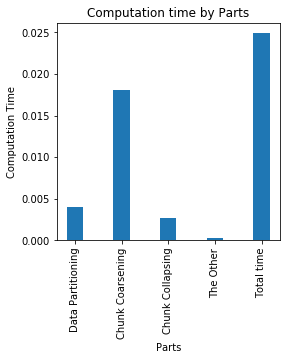

In [0]:
labels = ['Data Partitioning', 'Chunk Coarsening', 'Chunk Collapsing', 'The Other', 'Total time']
time_list = [partition_time, coarsening_time, collapsing_time, other_time, time_all]

x = np.arange(len(labels))
width = 0.35

fig, axes = plt.subplots(figsize=(4,4))

rect = axes.bar(x, time_list, width)
axes.set_xticks(x)
axes.set_xticklabels(labels, rotation='vertical')

axes.set_xlabel('Parts')
axes.set_ylabel('Computation Time')
axes.set_title('Computation time by Parts')

plt.show()